#1.Abstract



According to Wikipedia, Fake news is false or misleading information presented as news. 

Recently, fake news is becoming a worldwide problem. Through different media, we are easily exposed to and influenced by different stories.

We want to analyze the pattern of fake news and attempt to find a way to predict the truthfulness of news. Fake news detection on social media presents unique challenges. We are using an exsiting dataset, so we do not know if there is any mislabeling. By doing an EDA process, we hope to get a grasp of the characteristics of a fake news and figure out a method to determine them.

We plan to use different machine-learning mechanisms to build models for predictions. The current choices we are considering include Logistic Regression, Naive Bayes, and Neural Networks.

data link: https://drive.google.com/drive/folders/1vkOXyyswXLSdOhdM4GOSBgdemVXp8O7L?usp=sharing

#2.Import and Data Loading

In this part of the project, we import the packages needed for processing and modeling the data. We choose to mainly use pandas, numpy and nltk to process the data and text included in the datasets. In addition, we use wordcloud and seaborn to do data visualizations. We will also utlize machine learning libraray such as sklearn to build up models and design neural network to classify and analyze news.

In [ ]:
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_extraction
from sklearn.linear_model import SGDClassifier

import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding
from keras.initializers import Constant
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The dataset we used are from Kaggle (https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset). The dataset is made from two csv files, one with 23481 instances of fake news and the other with 21417 instances of real news. The labels of data include the title of the news, the text content of the news, the subject of the news and the date when the news were posted.

In [ ]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

A look at the loaded data.

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Checking the loaded data. We use info() and duplicated() to check for NaN and duplicate rows.

In [ ]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
len(fake_df[fake_df.duplicated()==True])

3

In [ ]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
len(real_df[real_df.duplicated()==True])

206

No entries contain NaN but duplicated entries found. Dropping the duplicated rows in each table.

In [ ]:
fake_df = fake_df.drop_duplicates()
real_df = real_df.drop_duplicates()
len(fake_df),len(real_df)

(23478, 21211)

#3.Preprocessing Data

Now, we have successfully loaded our datasets. The next step is to preprocess the datasets we loaded. Firstly, we want to add a column called 'isFake' to indicate that whether the news is fake or not (fake is 1 and real is 0). Since we think the length of the data is somewhat correlated to their truthfulness, we also choose to add a column 'text_length' to indicate the length of the text of the news. We then combine these two datasets into a new dataset contains both real news and fake news, which has 44689 instances.

In [ ]:
# add a new column of text length
fake_df['text_length'] = fake_df['text'].str.len()
real_df['text_length'] = real_df['text'].str.len()

# add column 'isFake'
fake_df['isFake'] = 1
real_df['isFake'] = 0

# concate the two datasets into a new dataset contains all news
news_df = pd.concat([real_df, fake_df])
news_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 44689 entries, 0 to 23480
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        44689 non-null  object
 1   text         44689 non-null  object
 2   subject      44689 non-null  object
 3   date         44689 non-null  object
 4   text_length  44689 non-null  int64 
 5   isFake       44689 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In this part of the project, we want to clean our data. Here are the steps we choose to clean and exact our data：

1. Remove external links which including tagging people(e.g. @musk) and parts of url(contains "http://", "@",".com", etc). 

2. Remove the names of news agencies (e.g. "The Washington Post", "The New York Times") and other indentiy indicators. (We only found "Reuters" inside the dataset, so we only removed Reuters)

3. Discard the contents containing useless information such as stop words, punctions and other non-alphabetic characters. 
 
4. Use stemmer to identify the words which are in different format but with the same meaning (e.g. "dogs" and "dog", "play" and "played"). 

In [ ]:
# get the stem and stop words
stop_words = stopwords.words('english')
stem = PorterStemmer()
# define the cleaning function
def text_cleaner(text):
  # exact words without external links  
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  text = re.sub(r'@[^s]*','', text)
  # some news contains "(Reuters)"  
  if "(Reuters)" in text:
    text = text.split("(Reuters)")[1]
  # exact words without "/", "\" and stop words
  words = [w for w in text.split() if "/" not in w and "\\" not in w and w not in stop_words]
  first_cleaned_text = " ".join(words)
  # remove the words with no information such as punctuation and digit
  cleaned_words = [w for w in first_cleaned_text if w not in string.punctuation or not w.isdigit()]
  second_cleaned_text = "".join(cleaned_words)
  second_cleaned_text = re.sub('[^a-zA-z\s]', '', second_cleaned_text).lower()
  # identify the words which are in different format but actually they are the same
  stem_words = [stem.stem(w) for w in second_cleaned_text.split()]
  final_text = " ".join(stem_words)
  return final_text

# test whether the function could acheive our requirements
text_cleaner(fake_df['text'][0])



'donald trump wish american happi new year leav that instead give shout enemi hater dishonest fake news media the former realiti show star one job it as countri rapidli grow stronger smarter i want wish friend support enemi hater even dishonest fake news media happi healthi new year presid angri pant tweet great year america as countri rapidli grow stronger smarter i want wish friend support enemi hater even dishonest fake news media happi healthi new year great year america donald j trump s tweet went welll expectwhat kind presid send new year greet like despic petti infantil gibberish onli trump hi lack decenc even allow rise gutter long enough wish american citizen happi new year bishop talbert swan s calvin stowel decemb your impeach would make great year america i also accept regain control congress miranda yaver self talk when includ mani peopl hate wonder whi hate me alan sandov se word hater new year wish marlen st say happi new year koren pollitt s trump new year eve tweet hap

We applied the data cleaning function to our dataset. Because of the long processing time, we saved the cleaned data into a new csv file. The new csv file is also in google drive link.

In [ ]:
# don't modify this cell, it will take long time!
# news_df['text'] = news_df['text'].apply(lambda x: text_cleaner(x))
# pd.DataFrame.to_csv(news_df, "cleaned_news.csv", index=False)

In [ ]:
cleaned_news_df = pd.read_csv('cleaned_news.csv')
cleaned_news_df['text']=cleaned_news_df['text'].astype(str)
cleaned_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        44689 non-null  object
 1   text         44689 non-null  object
 2   subject      44689 non-null  object
 3   date         44689 non-null  object
 4   text_length  44689 non-null  int64 
 5   isFake       44689 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


Checking the content of data...

In [ ]:
cleaned_news_df['text'][0]

'the head conserv republican faction us congress vote month huge expans nation debt pay tax cut call fiscal conserv sunday urg budget restraint in keep sharp pivot way among republican us repres mark meadow speak cb face nation drew hard line feder spend lawmak brace battl januari when return holiday wednesday lawmak begin tri pass feder budget fight like link issu immigr polici even novemb congression elect campaign approach republican seek keep control congress presid donald trump republican want big budget increas militari spend democrat also want proport increas nondefens discretionari spend program support educ scientif research infrastructur public health environment protect the trump administr alreadi will say were go increas nondefens discretionari spend percent meadow chairman small influenti hous freedom caucu said program now democrat say that enough need give govern pay rais percent for fiscal conserv i dont see rational is eventu run peopl money said meadow among republica

Processing the new dataset.

In [ ]:
cleaned_real_df = cleaned_news_df[cleaned_news_df['isFake']==0]
cleaned_fake_df = cleaned_news_df[cleaned_news_df['isFake']==1]

#4. Exploratory Data Analysis(EDA)

We have a total of 44689 instances of the news. 21211 of them are real news and 23478 of them are fake news. The following pie chart is a visualization of these data.

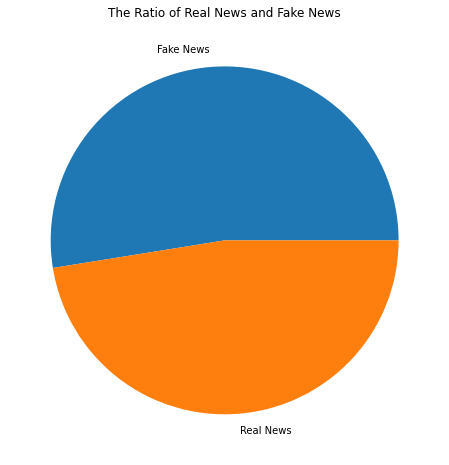

In [ ]:
plt.subplots(figsize = (8,8))
plt.title('The Ratio of Real News and Fake News')
plt.pie([len(fake_df),len(real_df)],labels=['Fake News','Real News'])
plt.show()

Exploring the distribution of the text length to see if there is any difference between real news and fake news in text length.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


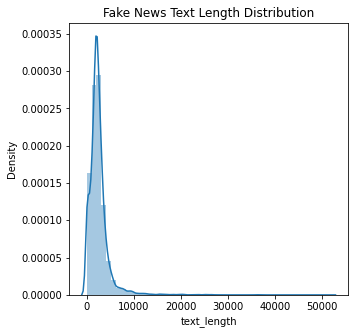

In [ ]:
plt.subplots(figsize=(5,5))
plt.title('Fake News Text Length Distribution')
sns.distplot(fake_df['text_length'])
plt.show()


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


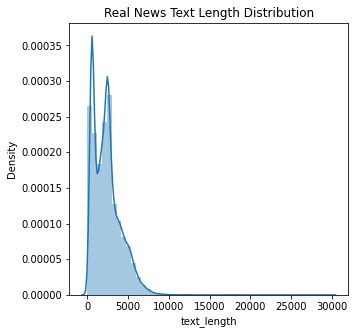

In [ ]:
plt.subplots(figsize=(5,5))
plt.title('Real News Text Length Distribution')
sns.distplot(real_df['text_length'])
plt.show()

The distribition of the text length of the Fake News and Real News are similar but with ceartain differences. Real news have two peaks in the text length distributions while fake news only have one; **however, we do not consider this to be a key feature that could differenciate fake news from real news.**



Exploring the subjects of the news.

In [ ]:
fake_sub_num = fake_df.groupby(by='subject').count().reset_index()[['subject','text']].rename(columns={'text':'news_number'})
fake_sub_num

,subject,news_number
0,Government News,1570
1,Middle-east,778
2,News,9050
3,US_News,783
4,left-news,4459
5,politics,6838


In [ ]:
real_sub_num = real_df.groupby(by='subject').count().reset_index()[['subject','text']].rename(columns={'text':'news_number'})
real_sub_num

,subject,news_number
0,politicsNews,11220
1,worldnews,9991


Visualizing the different subjects of fake news and real news.

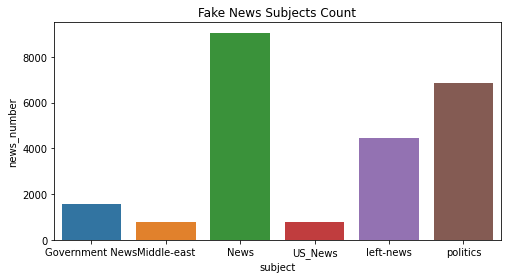

In [ ]:
plt.subplots(figsize=(8,4))
plt.title('Fake News Subjects Count')
sns.barplot(data=fake_sub_num, x='subject', y='news_number')
plt.show()

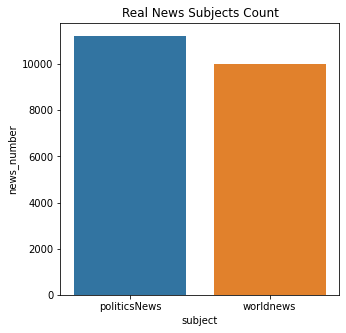

In [ ]:
plt.subplots(figsize=(5,5))
plt.title('Real News Subjects Count')
sns.barplot(data=real_sub_num, x='subject',y='news_number')
plt.show()

The subject counts of fake news and real news are diffenrent. Real news only have two kinds of subjects while fake news have six different subjects; **however, we do not consider this to be a key feature that could differenciate fake news from real news.**


Exploring the frequency of the words appearing in fake news and real news content. Since we are using the cleaned data, some words appear as word stems. The following are visualizations done with word cloud.

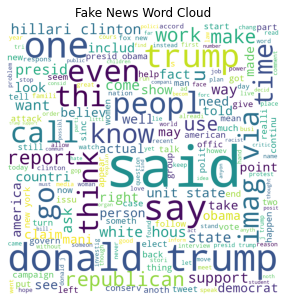

In [ ]:
fake_words = set([w for w in cleaned_fake_df['text']])
fake_text = ' '.join(fake_words)
fake_cloud = WordCloud(max_words=200, width=1000, height=1000, background_color='white').generate(fake_text)

plt.subplots(figsize=(10,5))
plt.title('Fake News Word Cloud')
plt.imshow(fake_cloud)
plt.axis('off')
plt.show()


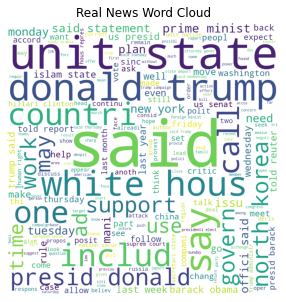

In [ ]:
real_words = set([w for w in cleaned_real_df['text']])
real_text = ' '.join(real_words)
real_cloud = WordCloud(max_words=200, width=1000, height=1000, background_color='white').generate(real_text)

plt.subplots(figsize=(10,5))
plt.title('Real News Word Cloud')
plt.imshow(real_cloud)
plt.axis('off')
plt.show()

According to the word cloud above, we notice that the words that appear in real news and fake news are somewhat similar. Most of them are related to US politics, especially president Donald Trump. 

Following are lists and bar plot of top words in fake news and real news.

In [ ]:
processed_fake_text = WordCloud().process_text(fake_text)

# we need to generate a dictionary which is word: frequency
fake_frequency = {word: count for word, count in sorted(processed_fake_text.items(), key=lambda x:-x[1])}
fake_frequency

{'said': 13702,
 'donald trump': 10888,
 'one': 10174,
 'say': 9772,
 'trump': 7954,
 'even': 7033,
 'peopl': 6770,
 'call': 6460,
 'thi': 6420,
 'go': 6212,
 'imag via': 6028,
 'think': 6012,
 'know': 5566,
 'time': 5332,
 'republican': 5164,
 'u': 4862,
 'make': 4732,
 'use': 4709,
 'work': 4652,
 'report': 4594,
 'hillari clinton': 4579,
 'white hous': 4521,
 'ask': 4508,
 'support': 4434,
 'come': 4406,
 'want': 4360,
 'presid': 4359,
 'way': 4322,
 'state': 4260,
 'unit state': 4229,
 'countri': 4194,
 'look': 4140,
 'america': 4091,
 'right': 3885,
 'see': 3883,
 'fact': 3858,
 'show': 3794,
 'includ': 3782,
 'well': 3754,
 'claim': 3674,
 'take': 3514,
 'need': 3459,
 'person': 3400,
 'mani': 3383,
 'believ': 3355,
 'told': 3310,
 'may': 3258,
 'made': 3252,
 'point': 3242,
 'actual': 3201,
 'obama': 3158,
 'democrat': 3153,
 'presid obama': 3092,
 'continu': 3073,
 'american': 3048,
 'man': 3019,
 'mean': 3015,
 'campaign': 2989,
 'talk': 2957,
 'attack': 2924,
 'vote': 2868,
 

In [ ]:
processed_real_text = WordCloud().process_text(real_text)
real_frequency = {word: count for word, count in sorted(processed_real_text.items(), key=lambda x:-x[1])}
real_frequency

{'said': 14550,
 'unit state': 11928,
 'donald trump': 9971,
 'say': 9670,
 'white hous': 8264,
 'includ': 6730,
 'countri': 6646,
 'one': 6623,
 'call': 5935,
 'presid donald': 5798,
 'north korea': 5423,
 'support': 5151,
 'govern': 5104,
 'work': 5067,
 'may': 4546,
 'ad': 4421,
 'use': 4283,
 'time': 4178,
 'prime minist': 4102,
 'issu': 3910,
 'said statement': 3824,
 'new york': 3677,
 'mani': 3594,
 'tuesday': 3561,
 'monday': 3560,
 'offici said': 3504,
 'need': 3500,
 'plan': 3499,
 'us presid': 3496,
 'told reuter': 3446,
 'trump said': 3390,
 'last year': 3368,
 'rule': 3365,
 'move': 3337,
 'islam state': 3333,
 'make': 3322,
 'barack obama': 3321,
 'go': 3293,
 'last week': 3293,
 'well': 3282,
 'wednesday': 3248,
 'even': 3143,
 'told report': 3120,
 'follow': 3102,
 'friday': 3081,
 'washington': 3050,
 'meet': 3046,
 'back': 3031,
 'sinc': 3028,
 'help': 3022,
 'part': 3015,
 'peopl': 3013,
 'thursday': 3008,
 'china': 2893,
 'presid barack': 2888,
 'ask': 2870,
 'chang

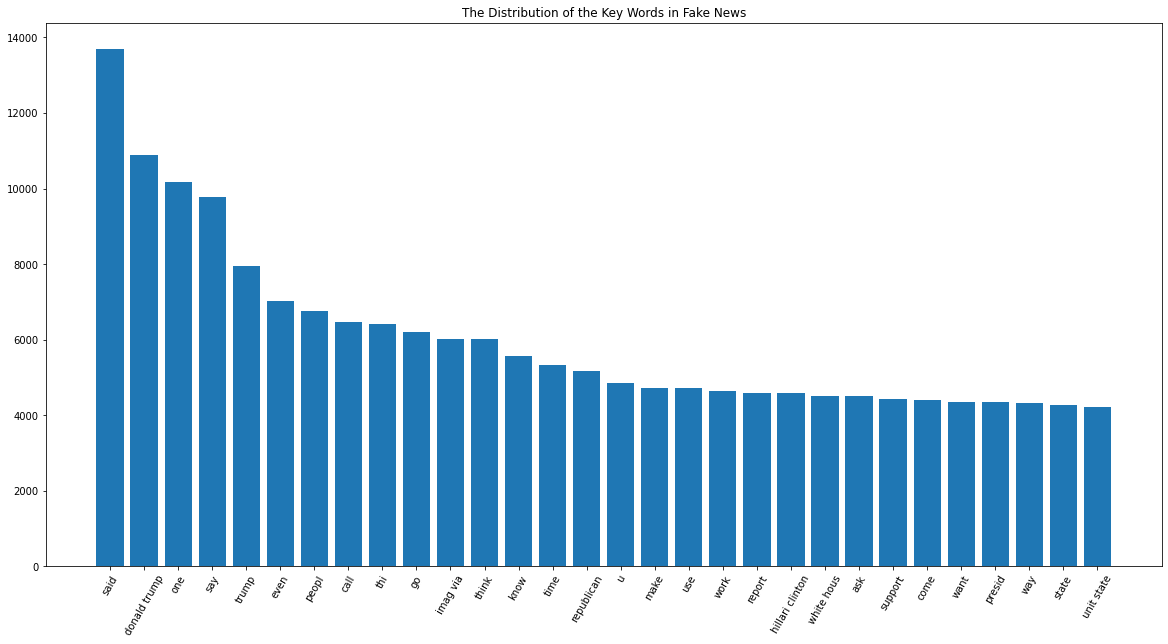

In [ ]:
# Then we could plot the top 30 most frequency words distribution
plt.figure(figsize = (20,10))
plt.xticks(rotation=60)
plt.title("The Distribution of the Key Words in Fake News")
plt.bar(list(fake_frequency.keys())[:30], list(fake_frequency.values())[:30])
plt.show()

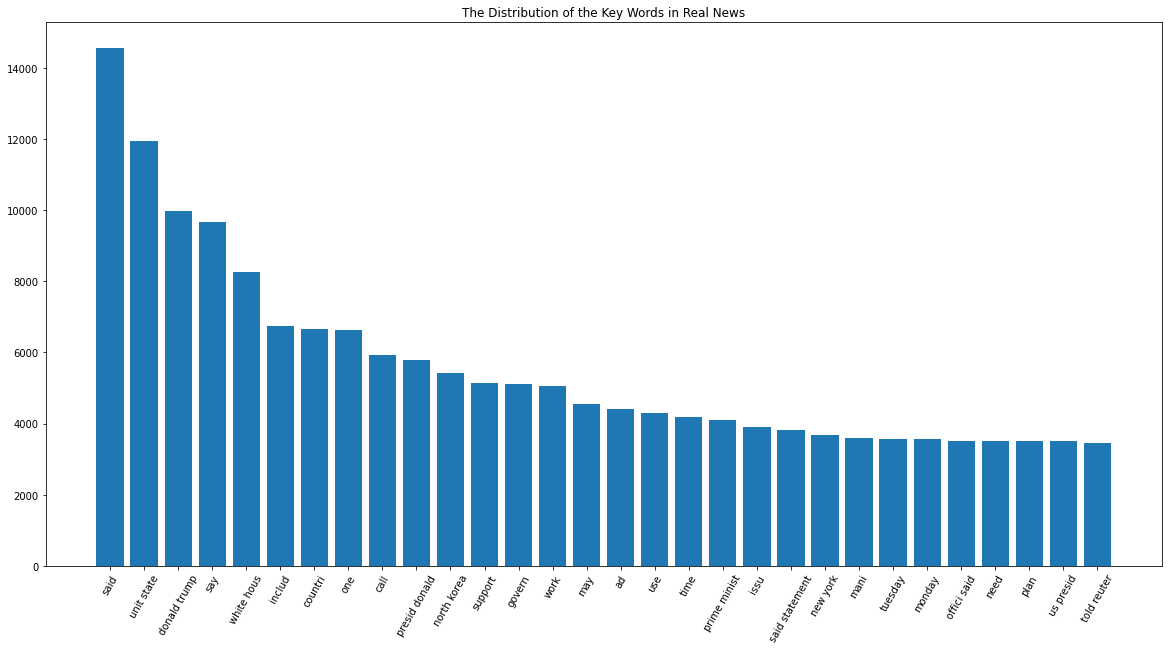

In [ ]:
plt.figure(figsize = (20,10))
plt.xticks(rotation=60)
plt.title("The Distribution of the Key Words in Real News")
plt.bar(list(real_frequency.keys())[:30], list(real_frequency.values())[:30])
plt.show()

The bar plots also show some similarities between fake news and real news; however, we think word frequency is the most significant attribute that differentiate fake news and real news.

As a results, we are building our models using this attribute.

#5.Modelling

##5.1 Split Data

Splitting the data (cleaned_news_df) into train set (80%) and test set (20%).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(cleaned_news_df['text'],cleaned_news_df['isFake'],test_size=0.2,random_state=10)
len(x_train),len(x_test)

(35751, 8938)

##5.2 Encode Text Data

To better process the data into Machine Learning models, We encode the text data into real number sparse matrix using the Term Frequency-Inverse Document Frequency (TFIDF). TFIDF transformation added 147877 features to each text data. 

In [ ]:
tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)
x_train.shape,x_test.shape

((35751, 147977), (8938, 147977))

## 5.3 Logistic Regression

Because we are doing binary classification, the first model we choose is Logistic Regression. Logistic Regression is a widely used for binary classification and it uses sigmoid funtion as activate function to classify the data.

In [ ]:
# build logistic regression model
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
# use the model to predict on the test set
y_pred_log = log_reg.predict(x_test)
# find the accuracy
log_acc = log_reg.score(x_test, y_test)
log_acc

0.9812038487357351

The accuracy of the trained logistic regression in test set is 98.12%, which is very high. 

A confusion matrix is generated to visualize the result. 

We also want to look at the $Recall = \frac {TP}{TP+FN}$ and $Precision = \frac {TP}{TP+FP}$ to envaluate our model.

The definition of Recall is: from all positive classes, how many did the model predict correctly. 

The definition of Precision is: from all the positive predictions, how many of them are actually positive. 

Both Recall and Precision should be as high as possible.

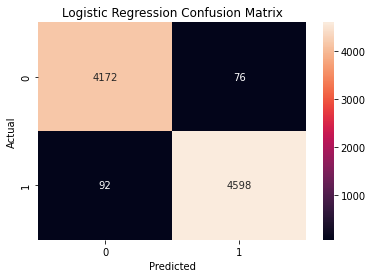

In [ ]:
# generate confusion matrix and visualize it
log_reg_cm = confusion_matrix(y_test, y_pred_log)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(log_reg_cm, annot = True, fmt='.20g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

According to the confusion matrix above, we can see that the TN=4172, FP=76, FN=92 and TP=4598. 

Hence we can get $Recall=\frac {4598}{4598+92}=0.9816$ and $Precision=\frac {4598}{4598+76}=0.9837$.

Both Recall and Precision are high.

## 5.4 Naive Bayes Model

Although we have good results from the Logistic Classification model, we want to consider other models to see if there is possible improvements. 

The second model we choose is Naive Bayes Model. Naive Bayes Model is based on applying Bayes' theorem with strong independence assumption between the features.

There are several different type of Naive Bayes Model based on different probability distribution such as Gaussian and Multinomial distribution. 

We decided to use Mutinomial Naive Bayes model becuase our data encoded using TDIDF better fits this model. 

In [ ]:
# built niave bayes model
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
# use the model to predict on the test set
y_pred_nb = nb_model.predict(x_test)
# find the accuracy
nb_acc = nb_model.score(x_test, y_test)
nb_acc

0.9333184157529648

The accuracy for Mutinomial Naive Bayes Model to predict the text data is 93.33%, which is not bad; however, it is lower then the accuracy from Logistic Regression model.

The confusion matrix is generated below.

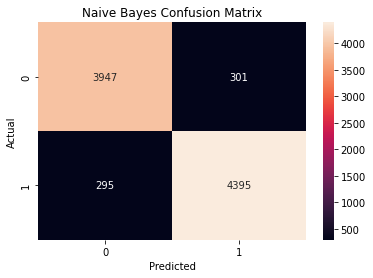

In [ ]:
# generate confusion matrix and visualize it
nb_cm = confusion_matrix(y_test, y_pred_nb)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(nb_cm, annot = True, fmt='.20g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Here TN=3947, FP=301, FN=295, TP=4395, we can get $Recall=\frac {4395}{295+4395} = 0.9371$ and $Precision = {4395}{4395+301} = 0.9359$. Which are also lower then the results from Logistic Regression model.

## 5.5 Support Vector Machine

Another useful supervised machine learning model is Support Vector Machine (SVM). It is also a widely used model with learning algorithms that analyze data for classification and regression analysis. SVM classify data entries by finding a hyperplane that maximize the margins for two classes, as the following image shows.

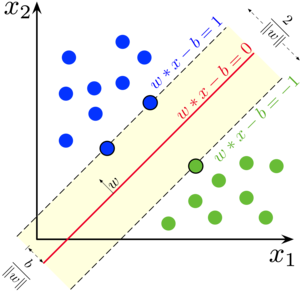

In [ ]:
# built niave bayes model
svm_model = SGDClassifier()
svm_model.fit(x_train, y_train)
# use the model to predict on the test set
y_pred_svm = svm_model.predict(x_test)
# find the accuracy
svm_acc = svm_model.score(x_test, y_test)
svm_acc

0.9838890132020586

The accuracy for the trained SVM model to predict the test data set is 98.39%, which is a little bit better than the accuracy from Logistic Regression!

The confusion matrix is generated below.

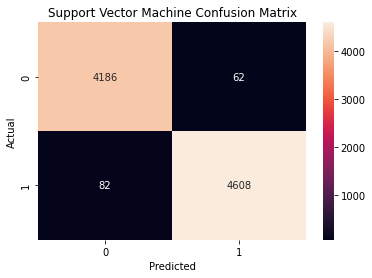

In [ ]:
# generate confusion matrix and visualize it
svm_cm = confusion_matrix(y_test, y_pred_svm)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(svm_cm, annot = True,fmt='.20g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Here TN=4186, FP = 62, FN = 56, TP = 4608, we can get $Recall = \frac{4608}{4608+82} = 0.9825$ and $Precision = {4608}{4608+62} = 0.9867$, which are also a bit higher then results from Logistic Regression (0.9816 and 0.9837).

##5.6 Bi-directional Long Short-Term Memory Model

Now, we have used three different machine learning model to classify real news and fake news. The accuracy of these models are good, but do we have a even better model? 

We are considering building a neural network; however, we only learned CNN from our class, which is not suitable to our data (we have text data rather than image data).

Therefore, we decided to use bi-directional LSTM (Long Short-Term Memory) **recurrent neural network**. Bi-directional long-short term memory is the process of making any neural network with the sequence information in both directions backward (furture to past) or forward (past to future). 

**Recurrent neural network (RNN)** is a type of neural network that is used to develop NLP models. RNN uses feedback loops to remember the sequence of the data and use the data pattern to predict. 

The reason that we use bi-directional LSTM is that the content that comes later in a text needs to be infered from the content that comes ealier in a text.

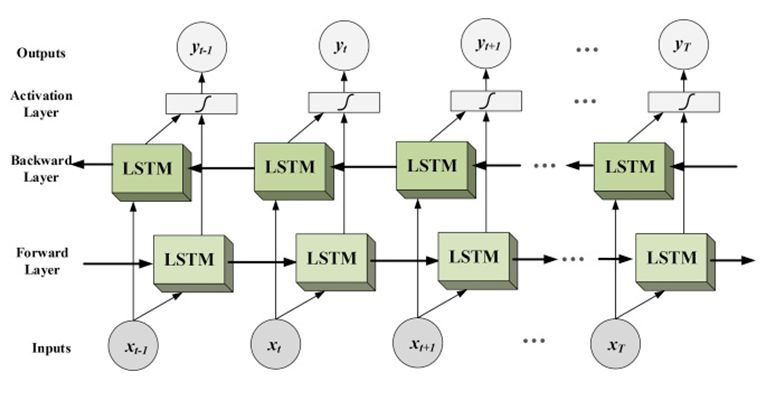

To apply Bi-LSTM RNN, we need to tokenized the text content of the news. 

After encoding, we have 5022 features rather than 147877 features. 

We choose to use fewer features because the RAM may not be enough for us to train the neural network with the original 147877 features.

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(cleaned_news_df['text'],cleaned_news_df['isFake'],test_size=0.2,random_state=10)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train2.values)
x_train2 = tokenizer.texts_to_sequences(x_train2.values)
x_train2 = pad_sequences(x_train2)
x_test2 = tokenizer.texts_to_sequences(x_test2.values)
x_test2 = pad_sequences(x_test2)

In [ ]:
x_train2.shape,x_test2.shape

((35751, 5022), (8938, 5022))

The structure of our RNN is: 

Input layer with 5022 features -> Bi-LSTM layers with 256 units (128 in each direction) -> Dropout layer with 256 units and 0.2 drop ratio (which is used to avoid overfitting) -> Dense layer with 64 units, we use ReLU as the activation function -> Output layer with sigmoid activation fuction to classify between 0/1.

In [ ]:
BRNN = Sequential()
BRNN.add(Embedding(len(tokenizer.word_index) + 1, 256, input_length = x_train2.shape[1]))
BRNN.add(Bidirectional(LSTM(128)))
BRNN.add(Dropout(0.2))
BRNN.add(Dense(64, activation = 'relu'))
BRNN.add(Dense(1,activation='sigmoid'))
BRNN.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(BRNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5022, 256)         37889024  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38,299,777
Trainable params: 38,299,777
Non-trainable params: 0
____________________________________________

In [ ]:
BRNN.fit(x_train2, y_train2, epochs=5, batch_size=128)

Epoch 1/5
280/280 [==============================] - 248s 860ms/step - loss: 0.1258 - accuracy: 0.9538
Epoch 2/5
280/280 [==============================] - 241s 861ms/step - loss: 0.0285 - accuracy: 0.9913
Epoch 3/5
280/280 [==============================] - 242s 864ms/step - loss: 0.0175 - accuracy: 0.9944
Epoch 4/5
280/280 [==============================] - 242s 864ms/step - loss: 0.0132 - accuracy: 0.9956
Epoch 5/5
280/280 [==============================] - 245s 877ms/step - loss: 0.0051 - accuracy: 0.9986


In [ ]:
score, accuracy= BRNN.evaluate(x_test2, y_test2, batch_size=128)
print("The accuracy of the LSTM in test data is ", accuracy)

70/70 [==============================] - 20s 281ms/step - loss: 0.0495 - accuracy: 0.9887
The accuracy of the LSTM in test data is  0.9886999130249023


The accuracy of using LSTM RNN to predict test set is 98.87%, which is the highest of all models!

In [ ]:
# predict by using test set
y_pred_lstm =np.round(BRNN.predict(x_test2)).astype(int) 

280/280 [==============================] - 39s 139ms/step


The confusion matrix is generated below.

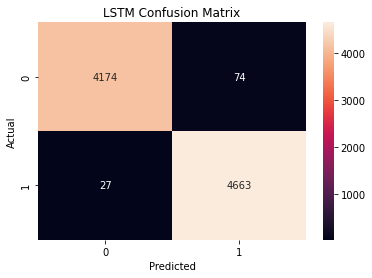

array([[4174,   74],
       [  27, 4663]])

In [ ]:
# generate confusion matrix and visualize it
lstm_cm= confusion_matrix(y_test2, y_pred_lstm)
plt.title("LSTM Confusion Matrix")
sns.heatmap(lstm_cm, annot = True, fmt='.20g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
lstm_cm

For confusion matrix, we have TN=4174, TP=74, FN=27, TP=4663 so that we can get $Recall=\frac {4663}{4663+27}=0.9942$ and $Precision = \frac {4663}{4663+74} = 0.9844$.

##5.7 Conclusion

Compare the accuracy, recall and precision of each model. 

In [ ]:
model_data = {'Accuracy':{'Logistic Regression':0.9812,"Naive Bayes":0.9333, "SVM":0.9839, "Bi-LSTM":0.9887},
        'Recall':{'Logistic Regression':0.9816,"Naive Bayes":0.9371, "SVM":0.9825, "Bi-LSTM":0.9942},
        'Precision':{'Logistic Regression':0.9837,"Naive Bayes":0.9359, "SVM":0.9867, "Bi-LSTM":0.9844}}
model_df = pd.DataFrame(model_data)
model_df
        

,Accuracy,Recall,Precision
Logistic Regression,0.9812,0.9816,0.9837
Naive Bayes,0.9333,0.9371,0.9359
SVM,0.9839,0.9825,0.9867
Bi-LSTM,0.9887,0.9942,0.9844


According to the dataframe above, we can see that all the machine learning models we used have accuracy, recall, and precision above 93%. 

We can conclude that all models are effective classifying fake news and real news. 

Several key results:
1. Naive Bayes is the "worst" model with lowest values in accuracy, recall and precision. 

2. Logistic Regression and SVM's performance are very similar. Although SVM is the better model in terms of all three metrics, it does not have very obvious advantages. 

3. Bi-LSTM RNN is the best model among these four models if we only consider these three metrics (accuracy, recall and precision); however, it is better by a small margin and takes a long time to train. 

Even though there isn't too much space for improvments, Bi-LSTM neural network is very strong because we only had 5022 features, which is much smaller than 147877 features that we used to train other three machine learning models. If we could solve the RAM problem, we may use more features to train the Bi-LSTM RNN, which may further improve the performance of it.

# 6.Challenges and Obstacles Faced

1. We had to change the topic of our project. Our initial topic was a data set named "Health Nutrition and Population" which was suggested in class. This dataset is hard to analyze because it covers a wide range of topics. Also, its structure is complicated and we had to spent time to reshape it in order to extract useful information. The biggest problem was the limited number of data entries. Because of the presence of many NaN, after cleaning the data, only 14k rows are left, which is not big enough for model such as neural network. After discussing with our TA, we switched to a new data set about fake news.

2. For our new dataset, data cleaning was the biggest obstacle. We spent a long time thinking about how to clean the 'text' column useful infomation can be extracted. In addition, applying our text cleaning function to the dataframe took us a long time; consequently, we decided to save the cleaned dataset to a new csv file (cleaned_news).

3. Since we are dealing with text data rather than image data, when building neural network, we choose a different model than convolutional neural network, which we learned in class. None of us have previous experience in natural language process, so we had to study together to find a new model. When applying LSTM BRNN model, we tried our best to build it in pytorch, so we eventually switched to keras, which required additional learning time.

#7. Future Direction

1. Consider including more features to train the models, for example, the comments of each news. To accomplish this, we need to find more complex dataset.

2. In LSTM model part, we failed to build it up using pytorch; however, since Pytorch is more flexible, dynamic, and has more efficient memory usage, we want to try to build the model again using pytorch.

3. We are currently using only binary classification models, if possible, we want to analyze the content of news using more complex models so we can have a complete view on their effects and influences.

4. Our TA suggested that we can use a number of different encoding method (Gpt3, bert, etc.), we want to consider them as another future improvement. 